## Grupo 23

**Nombre:** Raúl Miguel Carrero Martín 
**Nia**: 100451286 
**Grupo de clase**: 81

**Nombre:** Gonzalo Vela Sacristán
**Nia**: 100472334
**Grupo de clase**: 84

In [113]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install pickle
%pip install time
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


  Could not find a version that satisfies the requirement pickle (from versions: )
No matching distribution found for pickle
You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


  Could not find a version that satisfies the requirement time (from versions: )
No matching distribution found for time
You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Importación de los datos y librerias

In [114]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import time
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') 


# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch



## Importar los datos

In [115]:
data = pd.read_csv("data/Stars2.csv")
display(data)

# Copiamos los datos y los estandarizamos
# ==============================================================================
data_df = data[['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class']].copy()

print("Cantidad de filas y columnas: ", data_df.shape)
print("Nombre de las columnas: ", data_df.columns)




,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Blue,O
237,8829,537493.000000,1423.0000,-10.73,White,A
238,9235,404940.000000,1112.0000,-11.23,White,A


Cantidad de filas y columnas:  (240, 6)
Nombre de las columnas:  Index(['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class'], dtype='object')


In [116]:
# Mostramos las columnas con valores nulos
print("Columnas con valores nulos: ")
print(data_df.isnull().sum())

Columnas con valores nulos: 
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64


In [117]:
# Mostramos las columnas con NaN
print("Columnas con NaN: ")
print(data_df.isna().sum())

Columnas con NaN: 
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64


In [118]:
print("Estadísticas de las variables:")
print(data_df.describe())

Estadísticas de las variables:
        Temperature              L            R         A_M
count    240.000000     240.000000   240.000000  240.000000
mean   10497.462500  107188.361635   237.157781    4.382396
std     9552.425037  179432.244940   517.155763   10.532512
min     1939.000000       0.000080     0.008400  -11.920000
25%     3344.250000       0.000865     0.102750   -6.232500
50%     5776.000000       0.070500     0.762500    8.313000
75%    15055.500000  198050.000000    42.750000   13.697500
max    40000.000000  849420.000000  1948.500000   20.060000


# 1.- Kmeans 

In [119]:

def distancia(a, b):
    return np.sqrt(np.sum((a - b)**2))

def kmeans(datos, k, max_iter=100):
    np.random.seed(23)
    # Inicialización aleatoria de los centroides
    centroides_indices = np.random.choice(len(datos), k, replace=False)
    centroides = datos[centroides_indices]
    threshold = 0.001

    for iteration in range(max_iter):
        # Asignar cada punto al centroide más cercano
        asignaciones = []
        for dato in datos:
            distancias = []
            for centroide in centroides:
                distancias.append(distancia(dato, centroide))
            asignacion = np.argmin(distancias)
            asignaciones.append(asignacion)

        # Actualizar los centroides
        nuevos_centroides = []
        for j in range(k):
            puntos_asignados = []
            for i in range(len(datos)):
                punto_asignado = [datos[i], asignaciones[i]]
                if punto_asignado[1] == j:
                    puntos_asignados.append(datos[i])
            nuevo_centroide = np.mean(puntos_asignados, axis=0)
            nuevos_centroides.append(nuevo_centroide)
        nuevos_centroides = np.array(nuevos_centroides)

        d_centroides = []
        for i in range(k):
            d_centroides.append(distancia(centroides[i], nuevos_centroides[i]))
        if np.max(d_centroides) < threshold:
            print("Iteración final: ", iteration)
            print("Centroides finales: ", nuevos_centroides )
            break

        centroides = nuevos_centroides

    return centroides, asignaciones

# 2.- Encoding de los datos categóricos

Primero observamos los valores de las variables categóricas

In [120]:
print("Valores de la columna Color: ")
print(data_df.Color.unique())

print("Valores de la columna Spectral_Class: ")
print(data_df.Spectral_Class.unique())

Valores de la columna Color: 
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']
Valores de la columna Spectral_Class: 
['M' 'B' 'A' 'F' 'O' 'K' 'G']


Mapeamos los valores obtenidos de las columnas *Color* y *Spectral Class*.

In [121]:
# Establecemos una unificación de colores:
mapping_color = { 
    'Red': ['Red'],
    'Orange-Red': ['Orange-Red'],
    'Orange': ['Orange'],
    'Yellow-Orange': ['Pale yellow orange'],
    'Yellow': ['yellowish', 'Yellowish'],
    'White-Yellow': ['Yellowish White', 'yellow-white', 'White-Yellow'],
    'White': ['White', 'Whitish', 'white'],
    'Blue-White': ['Blue White', 'Blue white', 'Blue-white', 'Blue-White'],
    'Blue': ['Blue'],
}

# Establecemos una unificación de colores:
mapping_spectral = {
    'M': ['M'],
    'K': ['K'],
    'G': ['G'],
    'F': ['F'],
    'A': ['A'],
    'B': ['B'],
    'O': ['O'],
}

In [122]:
# Mapeamos los datos
for target_color, source_colors in mapping_color.items():
  data_df.loc[data_df.Color.isin(source_colors), 'Color'] = target_color

print("Valores de la columna Color: ")
print(data_df.Color.unique())

Valores de la columna Color: 
['Red' 'Blue-White' 'White' 'White-Yellow' 'Yellow-Orange' 'Blue' 'Orange'
 'Yellow' 'Orange-Red']


## 2.1.- One-Hot-Encoding

In [123]:
one_hot_df = data_df.copy()

encoder = OneHotEncoder()

# Ajustamos el codificador y transformamos las columnas
one_hot_encoded = encoder.fit_transform(one_hot_df[['Color', 'Spectral_Class']])

# Cogemos los nombres de las nuevas columnas
feature_names = encoder.get_feature_names_out(['Color', 'Spectral_Class'])

# Creamos un DataFrame con los datos transformados
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=feature_names)

# Eliminamos las columnas originales
one_hot_df = one_hot_df.drop(columns=['Color', 'Spectral_Class'])

# Añadimos las nuevas columnas
one_hot_df = pd.concat([one_hot_df, one_hot_encoded_df], axis=1)

display(one_hot_df)


,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Red,Color_White,Color_White-Yellow,Color_Yellow,Color_Yellow-Orange,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0.002400,0.1700,16.12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3042,0.000500,0.1542,16.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2600,0.000300,0.1020,18.70,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2800,0.000200,0.1600,16.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1939,0.000138,0.1030,20.06,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
236,30839,834042.000000,1194.0000,-10.63,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
237,8829,537493.000000,1423.0000,-10.73,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
238,9235,404940.000000,1112.0000,-11.23,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2.- Ordinal Encoding

In [124]:
# Obtenemos los colores ordenados (directamente del mapping!)
colors = list(mapping_color.keys())


oe = OrdinalEncoder(categories=[colors])
color_encoded = oe.fit_transform(data_df.Color.values.reshape(-1, 1))


# Obtenemos los colores ordenados (directamente del mapping!)
spectral = list(mapping_spectral.keys())


oe = OrdinalEncoder(categories=[spectral])
spectral_encoded = oe.fit_transform(data_df.Spectral_Class.values.reshape(-1, 1))

In [125]:
ordinal_df = data_df.copy()

# cambiamos los valores de las columnas categóricas a numéricas
ordinal_df['Color'] = color_encoded
ordinal_df['Spectral_Class'] = spectral_encoded

display(ordinal_df)


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,0.0,0.0
1,3042,0.000500,0.1542,16.60,0.0,0.0
2,2600,0.000300,0.1020,18.70,0.0,0.0
3,2800,0.000200,0.1600,16.65,0.0,0.0
4,1939,0.000138,0.1030,20.06,0.0,0.0
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,8.0,6.0
236,30839,834042.000000,1194.0000,-10.63,8.0,6.0
237,8829,537493.000000,1423.0000,-10.73,6.0,4.0
238,9235,404940.000000,1112.0000,-11.23,6.0,4.0


# 3.- Modelos

## 3.1- PCA

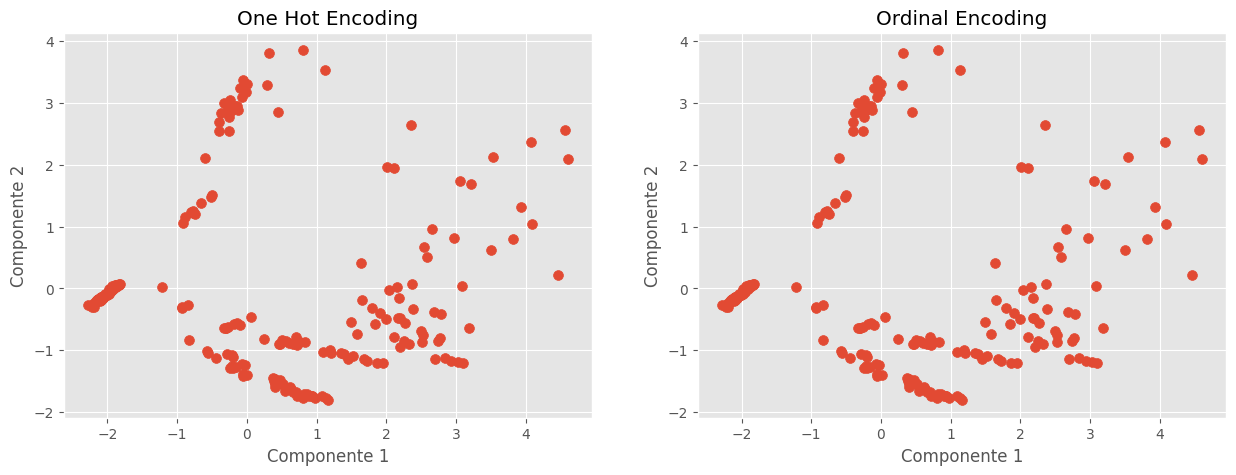

In [126]:

scaler = StandardScaler()
pca = PCA(n_components=2)

one_hot_scaled = scaler.fit_transform(ordinal_df)
ordinal_scaled = scaler.fit_transform(ordinal_df)

# Reducción de la dimensionalidad

X_one_hot_pca = pca.fit_transform(one_hot_scaled)
X_ordinal_pca = pca.fit_transform(ordinal_scaled)

# Represenantamos los datos en dos gráficas diferentes
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(X_one_hot_pca[:, 0], X_one_hot_pca[:, 1], s=50)
axs[0].set_title('One Hot Encoding')
axs[0].set_xlabel('Componente 1')
axs[0].set_ylabel('Componente 2')

axs[1].scatter(X_ordinal_pca[:, 0], X_ordinal_pca[:, 1], s=50)
axs[1].set_title('Ordinal Encoding')
axs[1].set_xlabel('Componente 1')
axs[1].set_ylabel('Componente 2')

plt.show()

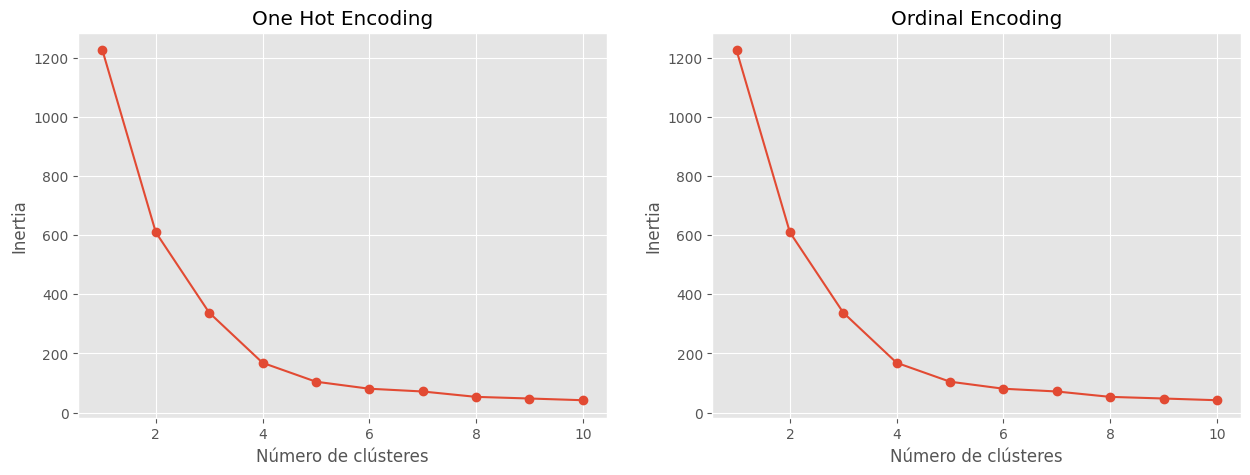

In [127]:

# Número óptimo de clústeres
# ==============================================================================
inertia_oh = []
inertia_ordinal = []
for i in range(1, 11):
    kmeans_inertia = KMeans(n_clusters=i, random_state=123).fit(X_ordinal_pca)
    inertia_ordinal.append(kmeans_inertia.inertia_)

for i in range(1, 11):
    kmeans_inertia = KMeans(n_clusters=i, random_state=123).fit(X_one_hot_pca)
    inertia_oh.append(kmeans_inertia.inertia_)

# Representación de los dato en dos gráficos
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(1, 11), inertia_oh, marker='o')
axs[0].set_title('One Hot Encoding')
axs[0].set_xlabel('Número de clústeres')
axs[0].set_ylabel('Inertia')

axs[1].plot(range(1, 11), inertia_ordinal, marker='o')
axs[1].set_title('Ordinal Encoding')
axs[1].set_xlabel('Número de clústeres')
axs[1].set_ylabel('Inertia')

plt.show()


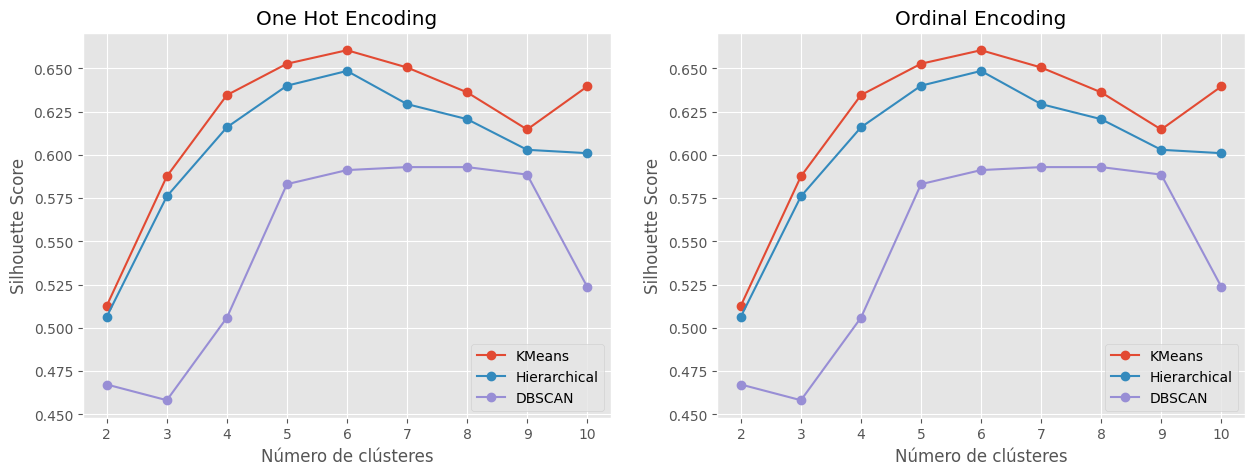

In [128]:
# Silhouette Score
silhouette_oh = []
silhouette_ordinal = []
for i in range(2, 11):
    kmeans_silhouette = KMeans(n_clusters=i, random_state=123).fit(X_ordinal_pca)
    silhouette_ordinal.append(silhouette_score(X_ordinal_pca, kmeans_silhouette.labels_))

for i in range(2, 11):
    kmeans_silhouette = KMeans(n_clusters=i, random_state=123).fit(X_one_hot_pca)
    silhouette_oh.append(silhouette_score(X_one_hot_pca, kmeans_silhouette.labels_))

# silhouette for hierarchical clustering
silhouette_hierarchical_oh = []
silhouette_hierarchical_ordinal = []
for i in range(2, 11):
    hierarchical = AgglomerativeClustering(n_clusters=i).fit(X_ordinal_pca)
    silhouette_hierarchical_oh.append(silhouette_score(X_ordinal_pca, hierarchical.labels_))

for i in range(2, 11):
    hierarchical = AgglomerativeClustering(n_clusters=i).fit(X_one_hot_pca)
    silhouette_hierarchical_ordinal.append(silhouette_score(X_one_hot_pca, hierarchical.labels_))

# silhouette for DBSCAN
silhouette_dbscan_oh = []
silhouette_dbscan_ordinal = []
for i in range(2, 11):
    dbscan = DBSCAN(eps=0.5, min_samples=i).fit(X_ordinal_pca)
    silhouette_dbscan_ordinal.append(silhouette_score(X_ordinal_pca, dbscan.labels_))

for i in range(2, 11):
    dbscan = DBSCAN(eps=0.5, min_samples=i).fit(X_one_hot_pca)
    silhouette_dbscan_oh.append(silhouette_score(X_one_hot_pca, dbscan.labels_))

# Representación de los datos en dos gráficos
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(2, 11), silhouette_oh, marker='o', label='KMeans')
axs[0].plot(range(2, 11), silhouette_hierarchical_oh, marker='o', label='Hierarchical')
axs[0].plot(range(2, 11), silhouette_dbscan_oh, marker='o', label='DBSCAN')
axs[0].set_title('One Hot Encoding')
axs[0].set_xlabel('Número de clústeres')
axs[0].set_ylabel('Silhouette Score')
axs[0].legend()

axs[1].plot(range(2, 11), silhouette_ordinal, marker='o', label='KMeans')
axs[1].plot(range(2, 11), silhouette_hierarchical_ordinal, marker='o', label='Hierarchical')
axs[1].plot(range(2, 11), silhouette_dbscan_ordinal, marker='o', label='DBSCAN')
axs[1].set_title('Ordinal Encoding')
axs[1].set_xlabel('Número de clústeres')
axs[1].set_ylabel('Silhouette Score')
axs[1].legend()

plt.show()

## 3.2.- Modelos para One Hot Encoding

### Algoritmo Kmeans

Iteración final:  4
Centroides finales:  [[-0.29079621 -0.90770912]
 [-2.02205121 -0.10007725]
 [ 0.90999306 -1.31236532]
 [ 2.74960727  0.10699807]
 [-0.71666571  1.35725052]
 [ 0.06378674  3.05551488]]


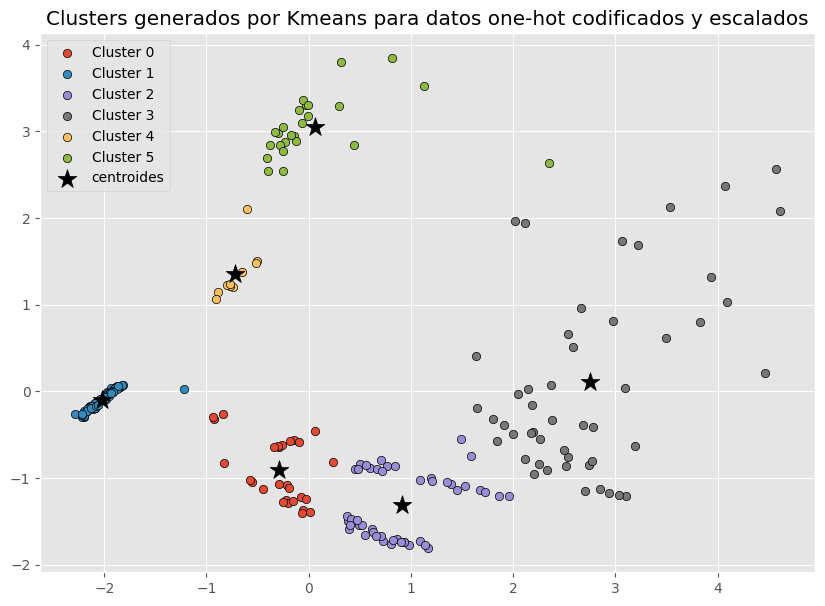

Tiempo de ejecución: 0.08545470237731934 segundos


In [129]:
# Aplicar KMeans a los datos transformados por PCA
n_clusters = 6
start = time.time()
centroides, asignaciones = kmeans(X_one_hot_pca, n_clusters)
end = time.time()

plt.figure(figsize=(10, 7))
for i in np.unique(asignaciones):
    plt.scatter(
        x = X_one_hot_pca[np.array(asignaciones) == i, 0],
        y = X_one_hot_pca[np.array(asignaciones) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.scatter(
    x = centroides[:, 0],
    y = centroides[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
plt.title('Clusters generados por Kmeans para datos one-hot codificados y escalados')
plt.legend()
plt.show()
print(f"Tiempo de ejecución: {end - start} segundos")

### Kmeans scikit

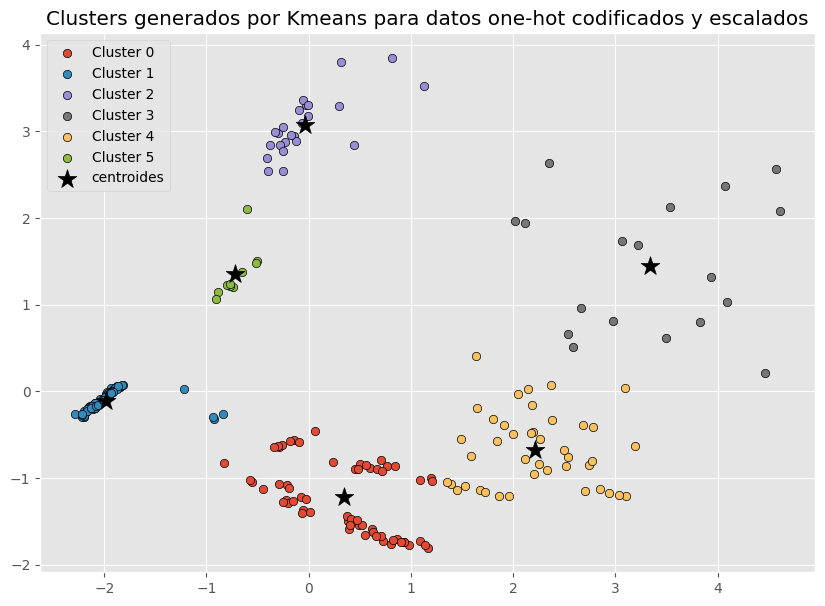

Tiempo de ejecución: 0.06487512588500977 segundos


In [130]:
# Kmeans with scikit-learn
start = time.time()
kmeans_scikit = KMeans(n_clusters=6, random_state=23)
kmeans_scikit.fit(X_one_hot_pca)
y_predict = kmeans_scikit.predict(X_one_hot_pca)

end = time.time()

plt.figure(figsize=(10, 7))
for i in np.unique(y_predict):
    plt.scatter(
        x = X_one_hot_pca[y_predict == i, 0],
        y = X_one_hot_pca[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.scatter(
    x = kmeans_scikit.cluster_centers_[:, 0],
    y = kmeans_scikit.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)

plt.title('Clusters generados por Kmeans para datos one-hot codificados y escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")

### Hierarchical cluster

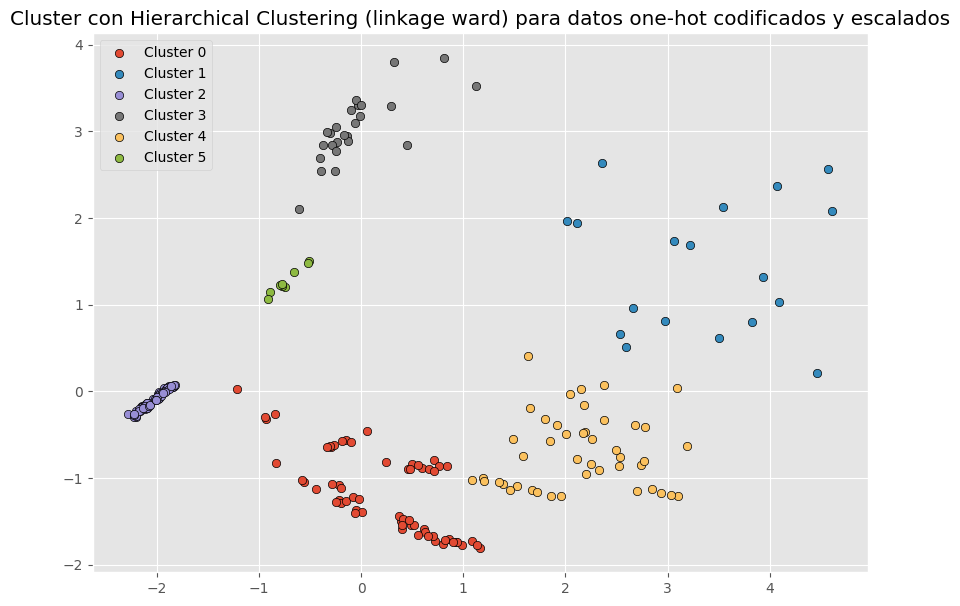

In [131]:
start = time.time()
# Clustering jerárquico
hc = AgglomerativeClustering(n_clusters=6, linkage = 'ward')
y_hc = hc.fit_predict(X_one_hot_pca)

end = time.time()

plt.figure(figsize=(10, 7))
for i in np.unique(y_hc):
    plt.scatter(
        x = X_one_hot_pca[np.array(y_hc) == i, 0],
        y = X_one_hot_pca[np.array(y_hc) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )
plt.title('Cluster con Hierarchical Clustering (linkage ward) para datos one-hot codificados y escalados')
plt.legend()
plt.show()


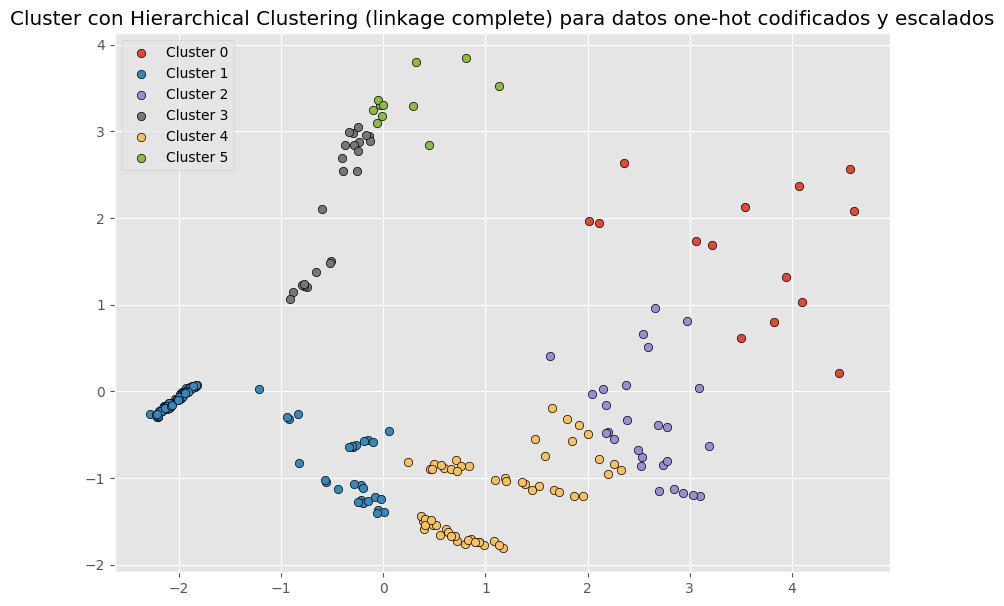

Tiempo de ejecución: 0.002001047134399414 segundos


In [132]:
# Hierarchical clustering with scikit-learn for linkage = 'complete'
start = time.time()
hc = AgglomerativeClustering(n_clusters=6, linkage = 'complete')
y_hc = hc.fit_predict(X_one_hot_pca)

end = time.time()

plt.figure(figsize=(10, 7))

for i in np.unique(y_hc):
    plt.scatter(
        x = X_one_hot_pca[np.array(y_hc) == i, 0],
        y = X_one_hot_pca[np.array(y_hc) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )
plt.title('Cluster con Hierarchical Clustering (linkage complete) para datos one-hot codificados y escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")

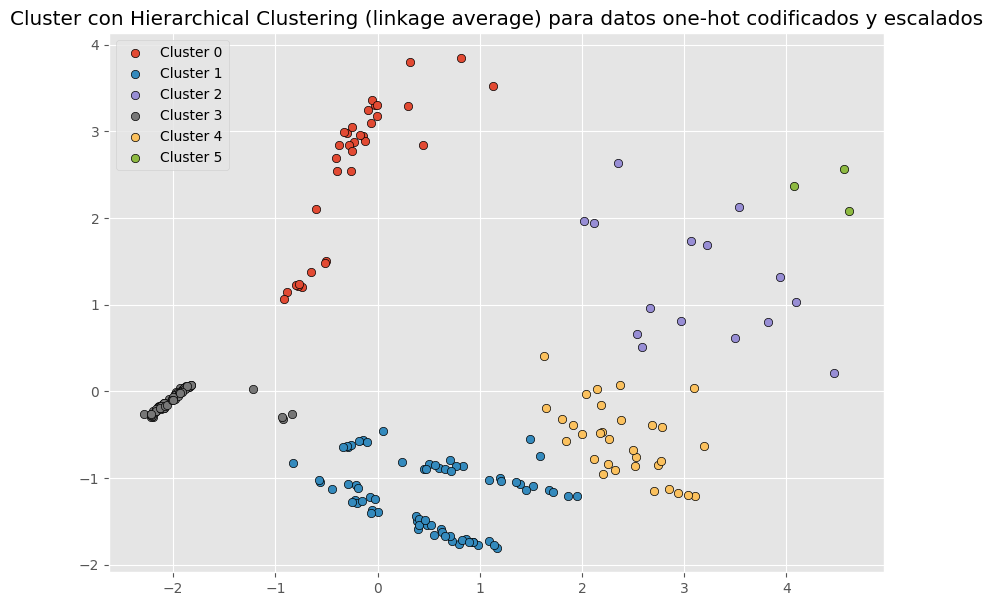

In [133]:
# hierarchical clustering with scikit-learn for linkage = 'average'
start = time.time()
hc = AgglomerativeClustering(n_clusters=6, linkage = 'average')
y_hc = hc.fit_predict(X_one_hot_pca)

end = time.time()

plt.figure(figsize=(10, 7))

for i in np.unique(y_hc):
    plt.scatter(
        x = X_one_hot_pca[np.array(y_hc) == i, 0],
        y = X_one_hot_pca[np.array(y_hc) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )
plt.title('Cluster con Hierarchical Clustering (linkage average) para datos one-hot codificados y escalados')
plt.legend()
plt.show()

### DBSCAN

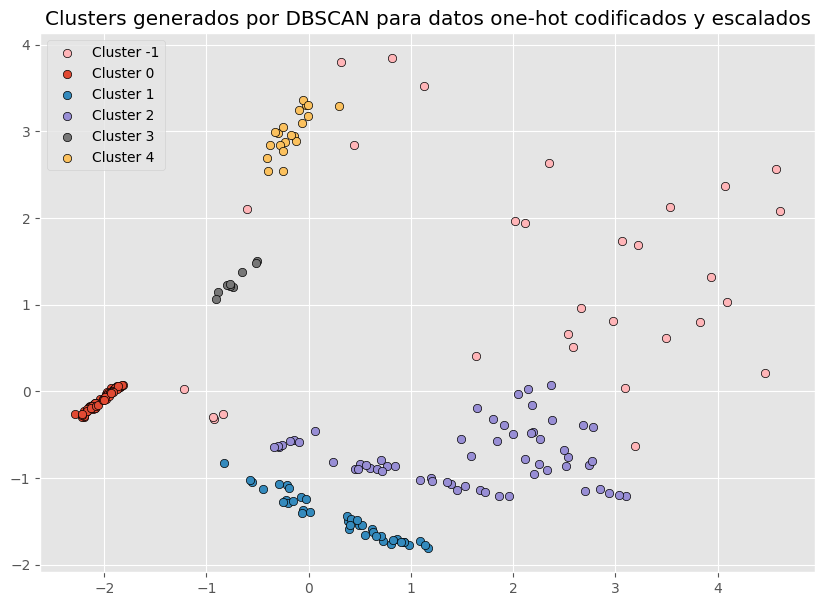

Tiempo de ejecución: 0.0030028820037841797 segundos


In [134]:
start = time.time()
# Entrenamos el modelo
dbscan = DBSCAN(eps=0.4, min_samples=5, metric= 'euclidean')
dbscan.fit(X_one_hot_pca)
end = time.time()
# Representamos los resultados
labels = dbscan.labels_

# show clusters
plt.figure(figsize=(10, 7))
for i in np.unique(labels):
    plt.scatter(
        x = X_one_hot_pca[labels == i, 0],
        y = X_one_hot_pca[labels == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.title('Clusters generados por DBSCAN para datos one-hot codificados y escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")

## 3.3.- Modelos con Ordinal Encoding

### Kmeans propio

Iteración final:  4
Centroides finales:  [[-0.29079621 -0.90770912]
 [-2.02205121 -0.10007725]
 [ 0.90999306 -1.31236532]
 [ 2.74960727  0.10699807]
 [-0.71666571  1.35725052]
 [ 0.06378674  3.05551488]]


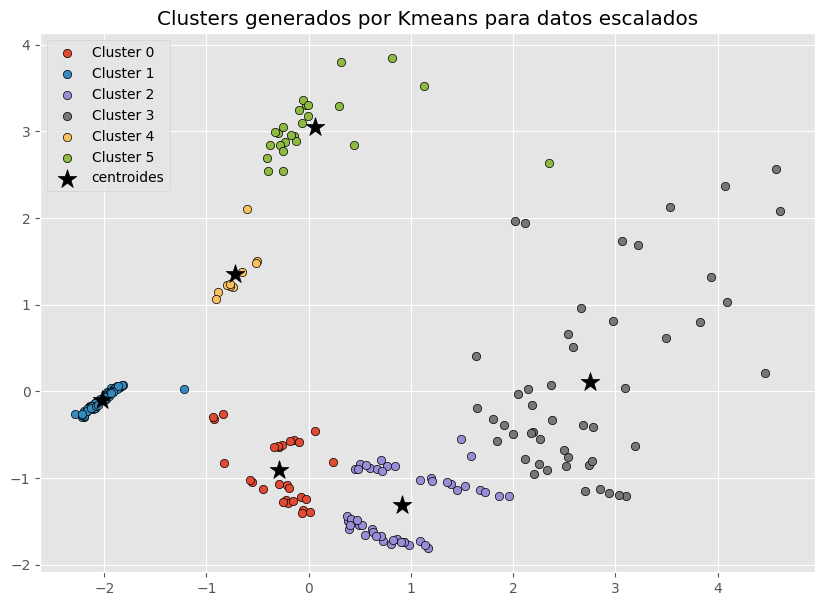

Tiempo de ejecución: 0.09489750862121582 segundos


In [135]:
n_clusters = 6
# Aplicar KMeans a los datos transformados por PCA
start = time.time()
centroides_oe, asignaciones_oe = kmeans(X_ordinal_pca, n_clusters)
end = time.time()
plt.figure(figsize=(10, 7))
for i in np.unique(asignaciones):
    plt.scatter(
        x = X_ordinal_pca[np.array(asignaciones_oe) == i, 0],
        y = X_ordinal_pca[np.array(asignaciones_oe) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.scatter(
    x = centroides_oe[:, 0],
    y = centroides_oe[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
plt.title('Clusters generados por Kmeans para datos escalados')
plt.legend()
plt.show()
print(f"Tiempo de ejecución: {end - start} segundos")

### Kmean scikit

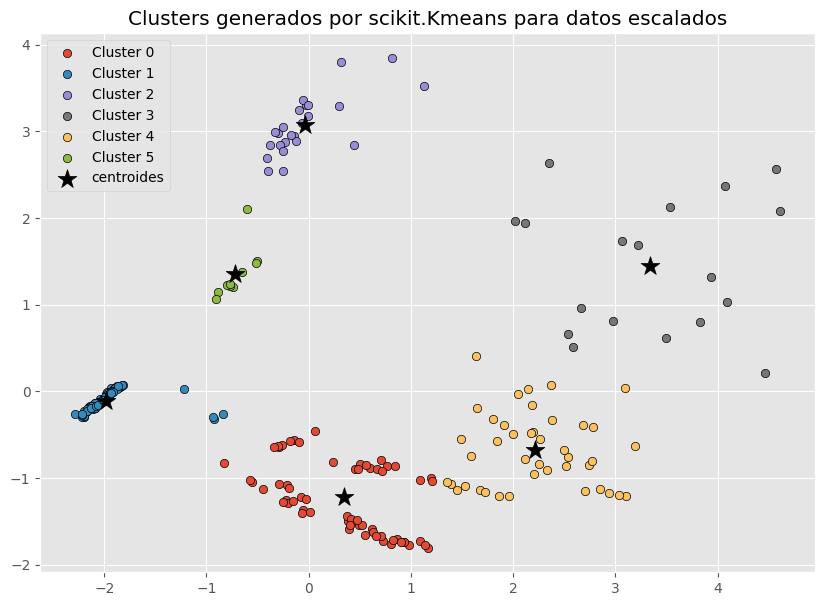

Tiempo de ejecución: 0.04883074760437012 segundos


In [136]:
start = time.time()
kmeans_scikit_oe = KMeans(n_clusters=6, random_state=23)
kmeans_scikit_oe.fit(X_ordinal_pca)
y_predict=kmeans_scikit_oe.predict(X_ordinal_pca)
end = time.time()

plt.figure(figsize=(10, 7))
for i in np.unique(y_predict):
    plt.scatter(
        x = X_ordinal_pca[np.array(y_predict) == i, 0],
        y = X_ordinal_pca[np.array(y_predict) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.scatter(
    kmeans_scikit_oe.cluster_centers_[:, 0],
    kmeans_scikit_oe.cluster_centers_[:, 1],
    s = 200,
    c = 'black',
    marker = '*',
    label  = 'centroides'
)
plt.title('Clusters generados por scikit.Kmeans para datos escalados')
plt.legend()
plt.show()
print(f"Tiempo de ejecución: {end - start} segundos")



### Hierarchical Clustering

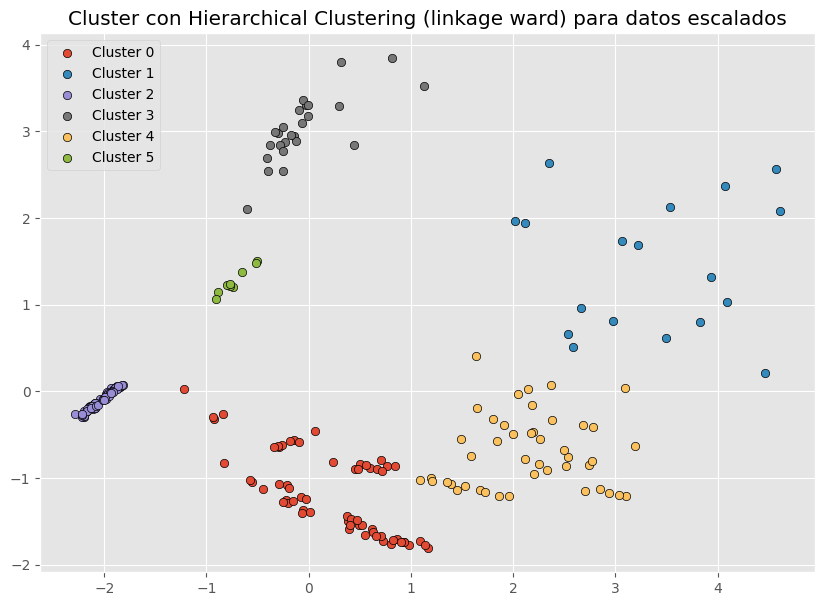

Tiempo de ejecución: 0.0020177364349365234 segundos


In [137]:
# Clustering jerárquico
start = time.time()
hc = AgglomerativeClustering(n_clusters=6, linkage = 'ward')
y_hc = hc.fit_predict(X_ordinal_pca)
end = time.time()

plt.figure(figsize=(10, 7))

for i in np.unique(y_hc):
    plt.scatter(
        x = X_ordinal_pca[np.array(y_hc) == i, 0],
        y = X_ordinal_pca[np.array(y_hc) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )
plt.title('Cluster con Hierarchical Clustering (linkage ward) para datos escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")

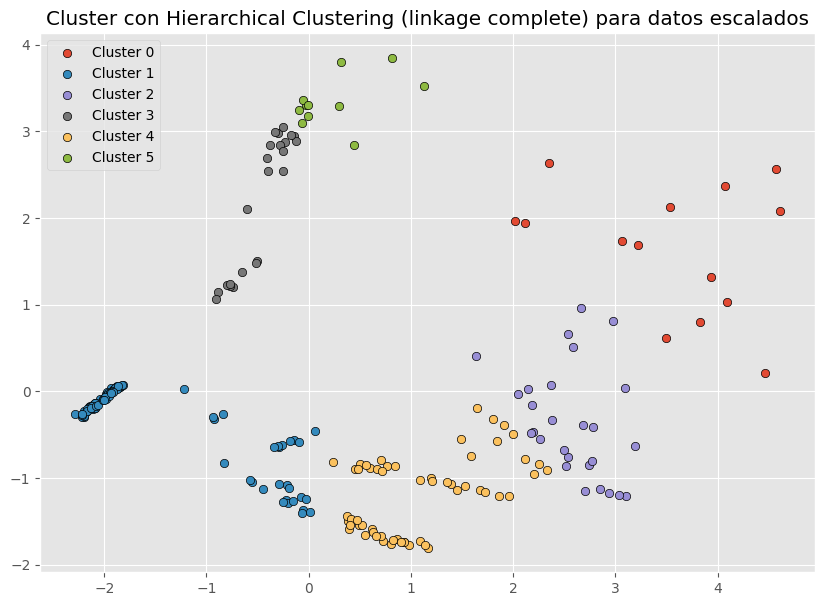

Tiempo de ejecución: 0.003882169723510742 segundos


In [138]:
# hierarchical clustering with scikit-learn for linkage = 'complete'
start = time.time()
hc = AgglomerativeClustering(n_clusters=6, linkage = 'complete')
y_hc = hc.fit_predict(X_ordinal_pca)
end = time.time()

plt.figure(figsize=(10, 7))

for i in np.unique(y_hc):
    plt.scatter(
        x = X_ordinal_pca[np.array(y_hc) == i, 0],
        y = X_ordinal_pca[np.array(y_hc) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.title('Cluster con Hierarchical Clustering (linkage complete) para datos escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")

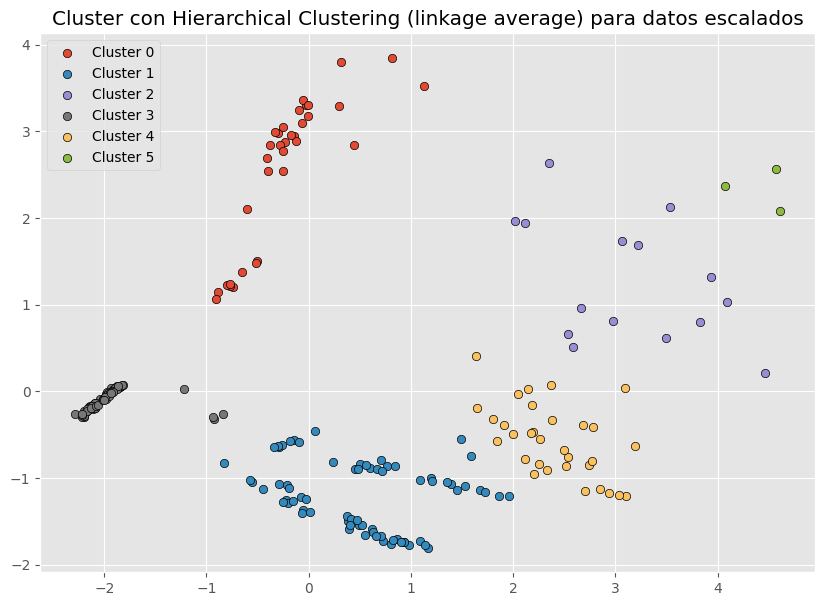

Tiempo de ejecución: 0.0019953250885009766 segundos


In [139]:
# hierarchical clustering with scikit-learn for linkage = 'average'
start = time.time()
hc = AgglomerativeClustering(n_clusters=6, linkage = 'average')
y_hc = hc.fit_predict(X_ordinal_pca)
end = time.time()

plt.figure(figsize=(10, 7))

for i in np.unique(y_hc):
    plt.scatter(
        x = X_ordinal_pca[np.array(y_hc) == i, 0],
        y = X_ordinal_pca[np.array(y_hc) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )
plt.title('Cluster con Hierarchical Clustering (linkage average) para datos escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")

### DBSCAN

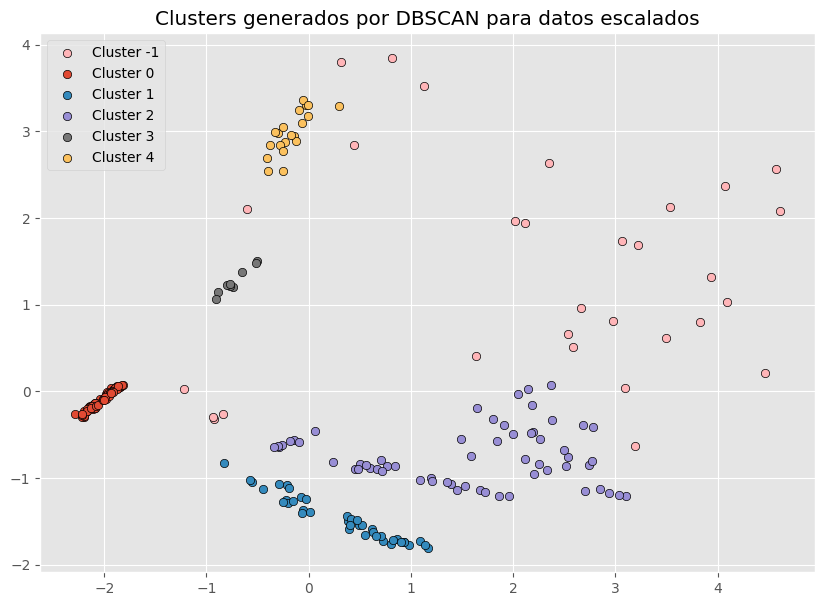

Tiempo de ejecución: 0.0029938220977783203 segundos


In [140]:
# dbscan
start = time.time()
dbscan = DBSCAN(eps=0.4, min_samples=5, metric= 'euclidean')
dbscan.fit(X_ordinal_pca)
end = time.time()

labels = dbscan.labels_

# show clusters
plt.figure(figsize=(10, 7))
for i in np.unique(labels):
    plt.scatter(
        x = X_ordinal_pca[labels == i, 0],
        y = X_ordinal_pca[labels == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.title('Clusters generados por DBSCAN para datos escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")